In [21]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_LSTM
import model_LSTM_attention
import model_Transformer_modified
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [22]:
# defining dataset locations
dataset_folder = "./datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                             gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                           gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [23]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=0)

### 1. Load LSTM

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_LSTM = torch.load(os.path.join("./LSTM_models", "LSTM_epoch100.pth"), map_location=torch.device(device))

criterion = nn.MSELoss()
model_LSTM = model_LSTM.LSTM(input_size=2, input_seq_len=8,
                             hidden_size=128, num_layers=3, output_size=2, output_seq_len=12).to(device)


model_LSTM = model_LSTM.to(device)
model_LSTM.load_state_dict(loaded_LSTM['model_state_dict'])

validation_loss_LSTM = loaded_LSTM['validation_loss']
val_mad_LSTM = loaded_LSTM['val_mad']
val_fad_LSTM= loaded_LSTM['val_fad']

In [25]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_LSTM.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        truth = data['trg'][:, :, 0:2].to(device)
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = data['src'][:, :, 0:2].to(device)

        # prediction till horizon lenght
        model_output = model_LSTM.forward(val_input)
        pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

        # calculating loss using pairwise distance of all predictions
        val_loss = criterion(model_output.view(val_input.size(0), -1), truth.contiguous().view(val_input.size(0), -1))
        batch_val_loss += val_loss.item()

        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt_LSTM = np.concatenate(gt, 0)
    pr_LSTM = np.concatenate(pr, 0)
    obs_LSTM = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt_LSTM, pr_LSTM)
    val_mad.append(mad)
    val_fad.append(fad)

### 2. Load LSTM with attention

In [26]:
loaded_LSTM_attn = torch.load(os.path.join("./LSTM_Attention_models", "LSTM_Attn_epoch100.pth"), map_location=torch.device(device))

criterion = nn.MSELoss()
model_LSTM_attn = model_LSTM_attention.LSTM_Dual_Attention(
        input_size = 2, input_seq_len = 8, hidden_size = 128, num_layers = 2, output_size = 2, output_seq_len = 12, embedding_size = 8, num_heads = 2).to(device)


model_LSTM_attn = model_LSTM_attn.to(device)
model_LSTM_attn.load_state_dict(loaded_LSTM_attn['model_state_dict'])

validation_loss_LSTM_attn = loaded_LSTM_attn['validation_loss']
val_mad_LSTM_attn = loaded_LSTM_attn['val_mad']
val_fad_LSTM_attn= loaded_LSTM_attn['val_fad']

In [27]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_LSTM_attn.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        truth = data['trg'][:, :, 0:2].to(device)
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = data['src'][:, :, 0:2].to(device)

        # prediction till horizon lenght
        model_output = model_LSTM_attn.forward(val_input)
        pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

        # calculating loss using pairwise distance of all predictions
        val_loss = criterion(model_output.view(val_input.size(0), -1), truth.contiguous().view(val_input.size(0), -1))
        batch_val_loss += val_loss.item()

        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt_LSTM_attn = np.concatenate(gt, 0)
    pr_LSTM_attn = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt_LSTM_attn, pr_LSTM_attn)
    val_mad.append(mad)
    val_fad.append(fad)

### 3. Transformer

In [28]:
mean=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).mean((0,1))
std=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).std((0,1))
means=[]
stds=[]
for i in np.unique(train_dataset[:]['dataset']):
    ind=train_dataset[:]['dataset']==i
    means.append(torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).mean((0, 1)))
    stds.append(
        torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).std((0, 1)))
mean=torch.stack(means).mean(0)
std=torch.stack(stds).mean(0)

In [29]:
loaded_Transformer = torch.load(os.path.join("./Transformer_models_v2", "raw_cosine_sgd_epoch100.pth"), map_location=torch.device(device))

model_Transformer = model_Transformer_modified.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048)


model_Transformer = model_Transformer.to(device)
model_Transformer.load_state_dict(loaded_Transformer['model_state_dict'])

# loading training metric variables
validation_loss_Transformer = loaded_Transformer['validation_loss']
val_mad_Transformer = loaded_Transformer['val_mad']
val_fad_Transformer = loaded_Transformer['val_fad']

In [30]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_Transformer.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = (data['src'][:, 1:, 2:4].to(
            device)-mean.to(device))/std.to(device)

        # input to decoder
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(
            1).repeat(val_input.shape[0], 1, 1).to(device)
        dec_inp = start_of_seq
        # decoder masks
        dec_source_mask = torch.ones(
            (val_input.shape[0], 1, val_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(
            dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

        # prediction till horizon lenght
        for i in range(horizon):
            # getting model prediction
            # model_output = model_loaded.forward(
            #     val_input, dec_inp, dec_source_mask, dec_target_mask)

            model_output = model_Transformer.forward(val_input, dec_inp)

            # appending the predicition to decoder input for next cycle
            dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

        # calculating loss using pairwise distance of all predictions
        val_loss = F.pairwise_distance(dec_inp[:, 1:, 0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                        contiguous().view(-1, 2).to(device)).mean() + \
            torch.mean(torch.abs(dec_inp[:, 1:, 2]))
        batch_val_loss += val_loss.item()

        # calculating the position for each time step of prediction based on velocity
        preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
            data['src'][:, -1:, 0:2].cpu().numpy()

        pr.append(preds_tr_b)
        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt_Transformer = np.concatenate(gt, 0)
    pr_Transformer = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt_Transformer, pr_Transformer)
    val_mad.append(mad)
    val_fad.append(fad)

In [31]:
gt_Transformer == gt_LSTM_attn

array([[[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       ...,

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]]])

### 4. trajectory prediction

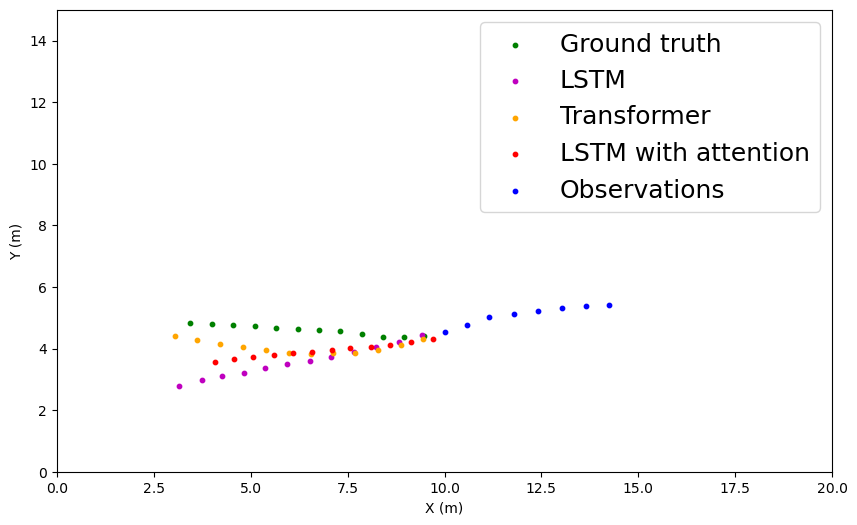

In [133]:
# plotting the predicted and ground truth trajectories
# idx = np.random.randint(0, gt_Transformer.shape[0])
idx = 4265
plt.figure(figsize=(10, 6))

plt.scatter(gt_Transformer[idx, :, 0], gt_Transformer[idx, :, 1], s=10, color='green', label="Ground truth")

# LSTM
plt.scatter(pr_LSTM[idx, :, 0], pr_LSTM[idx, :, 1], s=10, color='m', label="LSTM")


# Transformer
plt.scatter(pr_Transformer[idx, :, 0], pr_Transformer[idx, :, 1], s=10, color='orange', label="Transformer")

# LSTM with attention
plt.scatter(pr_LSTM_attn[idx, :, 0], pr_LSTM_attn[idx, :, 1], s=10, color='red', label="LSTM with attention")


plt.scatter(obs[idx, :, 0], obs[idx, :, 1], s=10, color='b', label="Observations")
plt.legend(fontsize=18)
plt.xlim(0, 20)
plt.ylim(0, 15)
# plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("final_result_traj_{}".format(idx), bbox_inches='tight', dpi=500)

plt.show()

In [105]:
idx

3981

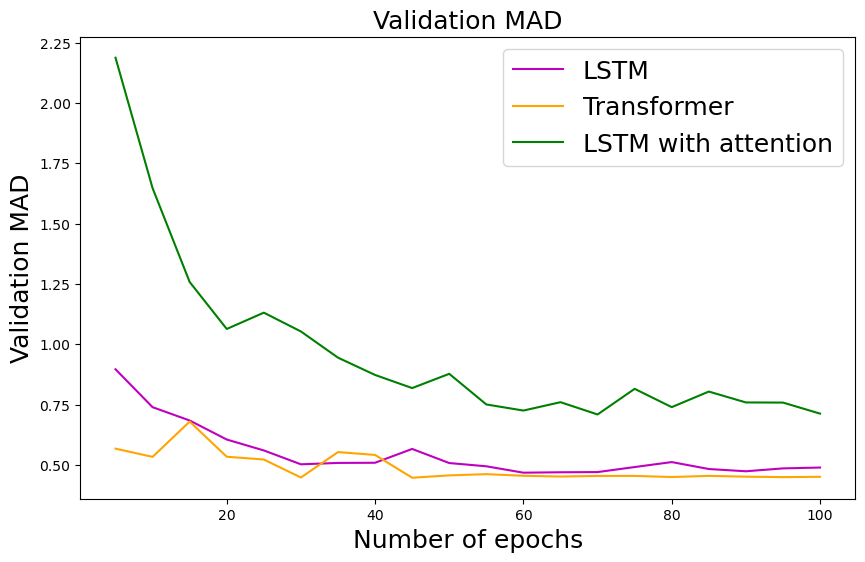

In [201]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(5, 101, 5),val_mad_LSTM, color='m', label="LSTM")
plt.plot(np.arange(5, 101, 5),val_mad_Transformer, color='orange', label="Transformer")
plt.plot(np.arange(5, 101, 5),val_mad_LSTM_attn, color='g', label="LSTM with attention")

plt.xlabel("Number of epochs", fontsize=18)
plt.ylabel("Validation MAD",fontsize=18)
plt.title("Validation MAD", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("final_result_MAD", bbox_inches='tight', dpi=500)


In [172]:
len(lables)

20

In [188]:
len(val_mad_LSTM)

20

In [192]:
np.arange(1, 101, 5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])

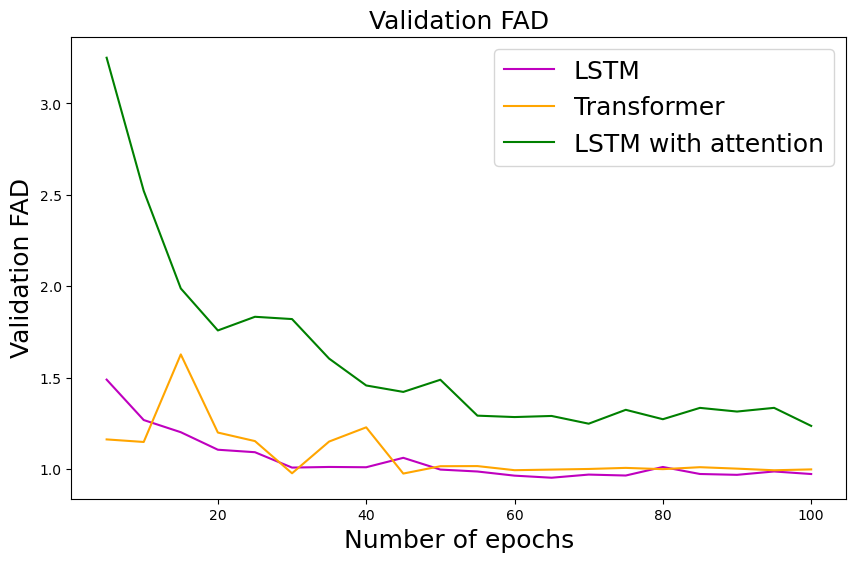

In [202]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(5, 101, 5),val_fad_LSTM, color='m', label="LSTM")
plt.plot(np.arange(5, 101, 5),val_fad_Transformer, color='orange', label="Transformer")
plt.plot(np.arange(5, 101, 5),val_fad_LSTM_attn, color='g', label="LSTM with attention")

plt.xlabel("Number of epochs", fontsize=18)
plt.ylabel("Validation FAD", fontsize=18)
plt.title("Validation FAD", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("final_result_FAD", bbox_inches='tight', dpi=500)
